In [ ]:
!pip install imbalanced-learn
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install kagglehub

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, KFold
import os
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as trans
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import random_split
import kagglehub

In [ ]:
path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')
path = os.path.join(path, "hmnist_28_28_RGB.csv")
df = pd.read_csv(path)

X = df.drop("label", axis=1).values
y = df["label"].values
X = X.reshape(-1, 28, 28, 3).astype(float)

oversample = RandomOverSampler(random_state=42)
X_flat = X.reshape(X.shape[0], -1)
X_resampled_flat, y = oversample.fit_resample(X_flat, y)


X_resampled = X_resampled_flat.reshape(-1, 28, 28, 3)
X_resampled = np.transpose(X_resampled, (0, 3, 1, 2))


k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

Resuming download from 1123024896 bytes (4459889615 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/kmader/skin-cancer-mnist-ham10000?dataset_version_number=2 (1123024896/5582914511) bytes left.


 20%|██        | 1.05G/5.20G [01:52<19:07:02, 64.7kB/s]

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if img.shape == (28, 28, 3):
            img = np.transpose(img, (2, 0, 1))
        elif img.shape != (3, 28, 28):
            if img.dtype != np.uint8:
                img = img.clip(0, 255).astype(np.uint8)
            img = np.ascontiguousarray(img)
            pass
        img = torch.from_numpy(img)


        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
transform_train = trans.Compose([
    trans.ToPILImage(),
    # trans.RandomHorizontalFlip(),
    # trans.RandomRotation(30),
    # trans.RandomResizedCrop(28, scale=(0.8, 1.0)),
    # trans.ColorJitter(brightness=0.2, contrast=0.2),
    trans.ToTensor(),
    trans.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = trans.Compose ([
    trans.ToPILImage(),
    trans.ToTensor(),
    trans.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
dataset = SkinCancerDataset(X_resampled, y, transform=transform_train)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)


In [ ]:
class Skipping(nn.Module):

  def __init__(self, in_channels, out_channels, pool):
    super().__init__()

    self.shortcut = nn.Conv2d(in_channels, out_channels, 3, padding=1)

    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.pool = nn.MaxPool2d(2) if pool else nn.Identity()
    self.dropout = nn.Dropout2d(0.3)
    self.relu = nn.ReLU()

  def forward(self, x):

    identity = self.shortcut(x)
    out = self.relu(self.bn1(self.conv1(x)))
    out = self.relu(self.bn2(self.conv2(out)))

    out = out + identity

    out = self.pool(out)
    out = self.dropout(out)

    return out

In [ ]:
class SkinCancer(nn.Module):

  def __init__(self):
    super(SkinCancer, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)

    self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
    self.bn4 = nn.BatchNorm2d(256)

    self.fc1 = nn.Linear(256, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 7)

    self.relu = nn.ReLU()
    self.drop_fc = nn.Dropout()
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):

    x = self.pool(self.relu(self.bn1(self.conv1(x))))
    x = self.pool(self.relu(self.bn2(self.conv2(x))))
    x = self.pool(self.relu(self.bn3(self.conv3(x))))
    x = self.pool(self.relu(self.bn4(self.conv4(x))))

    x = torch.flatten(x, 1)
    x = self.drop_fc(self.relu(self.fc1(x)))
    x = self.drop_fc(self.relu(self.fc2(x)))
    x = self.fc3(self.drop_fc(x))


    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = SkinCancer().to(device)

if not os.path.exists('models'):
  os.makedirs('models')
loaded = os.path.exists('./models/skin_cancer.pth')

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Using device: cuda


In [ ]:
def evaluate(test_loader, model, loss_function, label_true=[], label_pred=[]):
  model.eval()


  with torch.no_grad():
    for images, labels in test_loader:

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = loss_function(outputs, labels)
      _, preds = torch.max(outputs, 1)


      label_true.extend(labels.cpu().numpy())
      label_pred.extend(preds.cpu().numpy())

  cm = confusion_matrix(label_true, label_pred)
  print(ConfusionMatrixDisplay(cm, display_labels=np.unique(label_true)).plot())
  print(classification_report(label_true, label_pred))

In [ ]:
def train(train_loader, val_loader, loss_function, optimizer, model, device, epochs=100, patience=10):

  start_pat = patience

  best_loss = 100.0
  model.train()

  for epoch in range(epochs):
    print(f'Training epoch {epoch+1}...')

    total_loss = 0

    for images, labels in train_loader:

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(images).to(device)
      loss = loss_function(outputs, labels)

      total_loss += loss.item()

      loss.backward()
      optimizer.step()
      scheduler.step(loss.item())

    cur_loss = total_loss/len(train_loader)

    if not cur_loss<best_loss:
      patience -= 1
      if patience == 0:
        return 'Stopped early'
    else:
      best_loss = cur_loss
      patience = start_pat


    evaluate(val_loader, model, loss_function)

    print(f'Loss: {cur_loss:.4f}')

In [ ]:
if not loaded:
  train(
      train_loader,
      val_loader,
      loss_function,
      optimizer,
      SkinCancer(),
      device,
      epochs=30
  )
else:
  model.load_state_dict(torch.load('./models/skin_cancer.pth'))


--- Fold 1 ---
Training epoch 1...
              precision    recall  f1-score   support

           0       0.54      0.92      0.68      1371
           1       0.67      0.49      0.57      1374
           2       0.64      0.46      0.53      1353
           3       0.96      0.88      0.92      1312
           4       0.85      0.57      0.68      1351
           5       0.93      0.99      0.96      1329
           6       0.57      0.68      0.62      1297

    accuracy                           0.71      9387
   macro avg       0.74      0.71      0.71      9387
weighted avg       0.73      0.71      0.71      9387

Loss: 1.4241
Training epoch 2...
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      2742
           1       0.81      0.67      0.74      2748
           2       0.69      0.61      0.65      2706
           3       0.97      0.94      0.96      2624
           4       0.83      0.61      0.70      2702
         

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28791
           1       0.97      0.96      0.97     28854
           2       0.91      0.93      0.92     28413
           3       0.99      0.99      0.99     27552
           4       0.93      0.83      0.88     28371
           5       0.99      0.99      0.99     27909
           6       0.88      0.94      0.91     27237

    accuracy                           0.95    197127
   macro avg       0.95      0.95      0.95    197127
weighted avg       0.95      0.95      0.95    197127

Loss: 0.0284
Training epoch 22...
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     30162
           1       0.97      0.96      0.97     30228
           2       0.92      0.94      0.93     29766
           3       0.99      0.99      0.99     28864
           4       0.93      0.83      0.88     29722
           5       0.99      1.00      0.99 

ValueError: Unknown format code 'f' for object of type 'str'

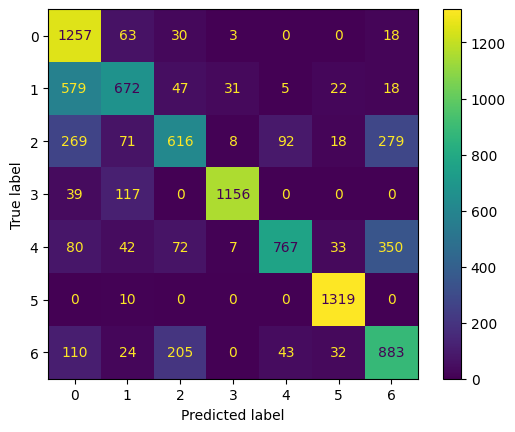

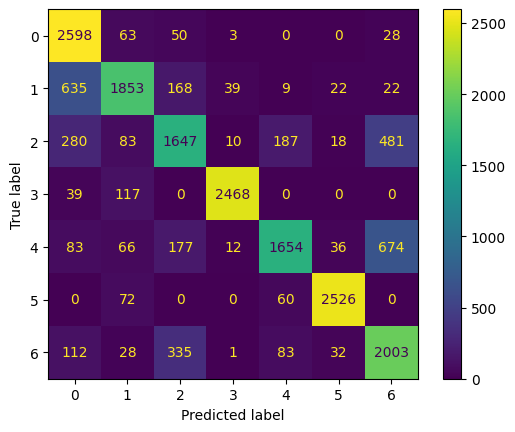

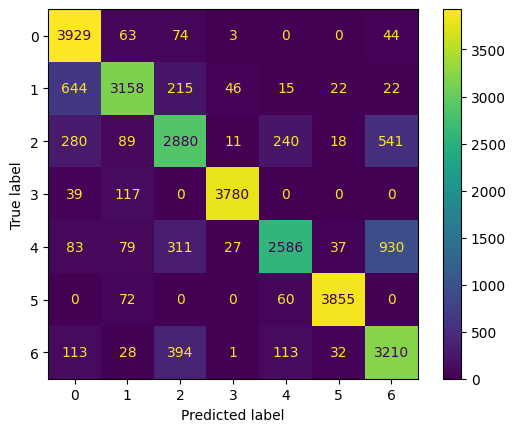

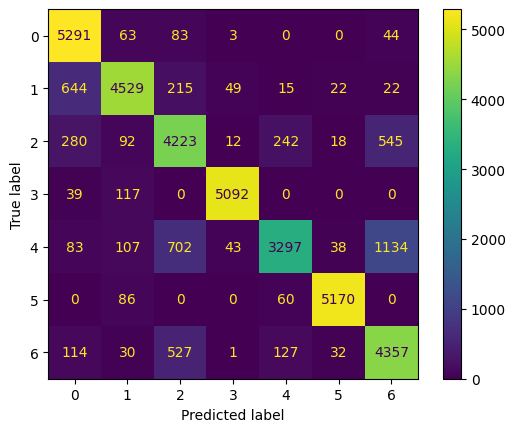

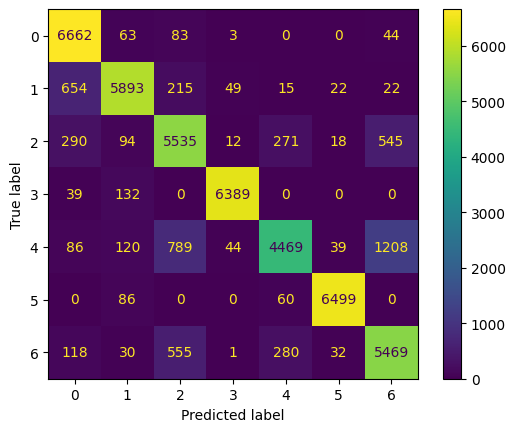

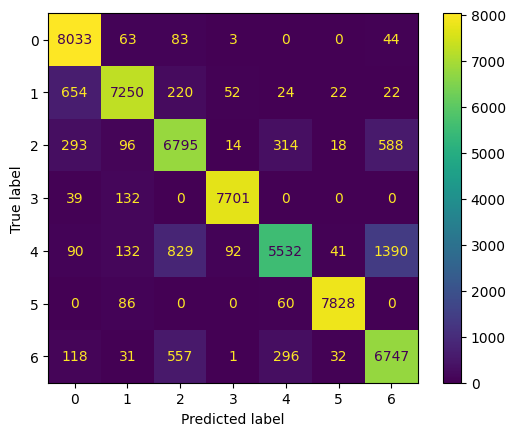

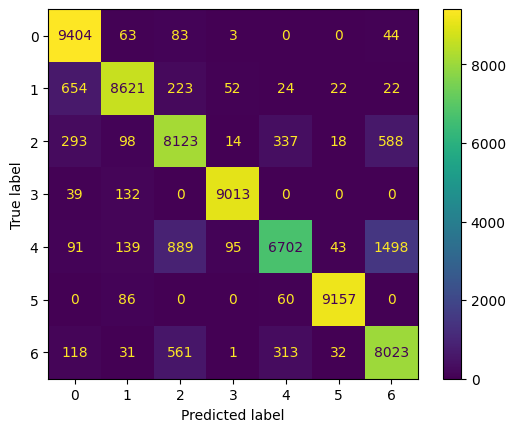

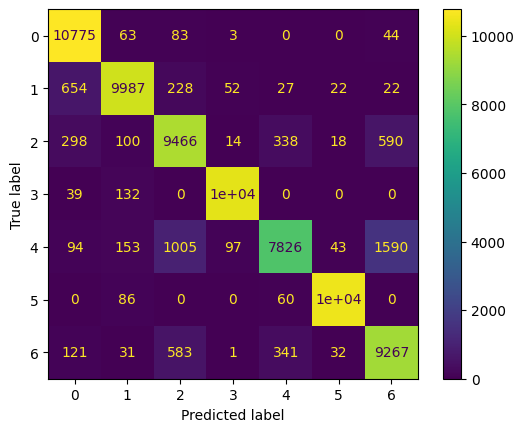

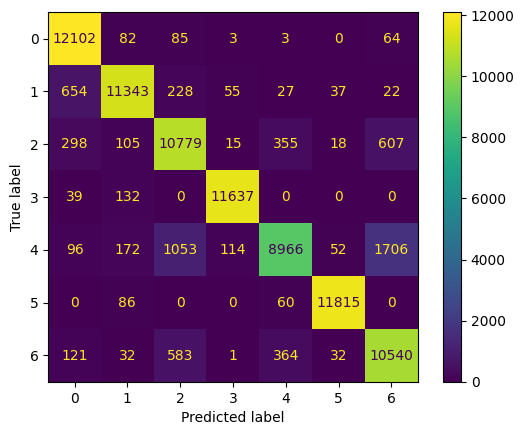

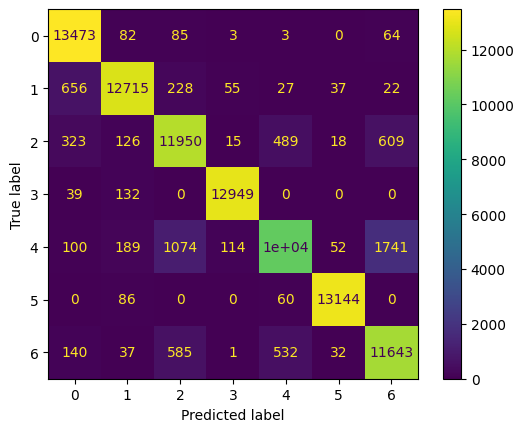

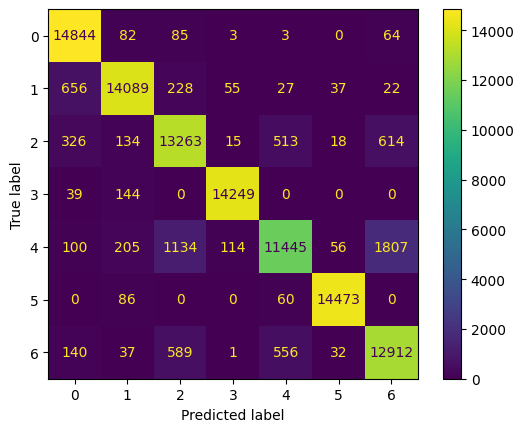

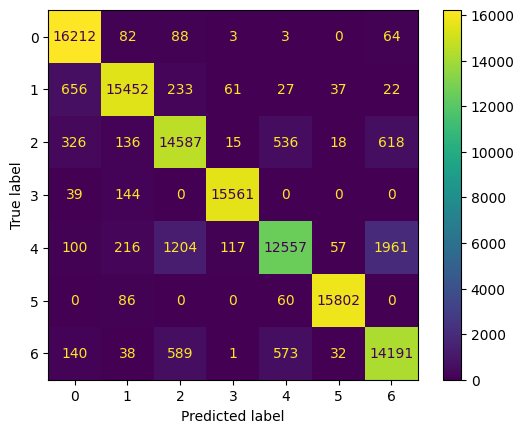

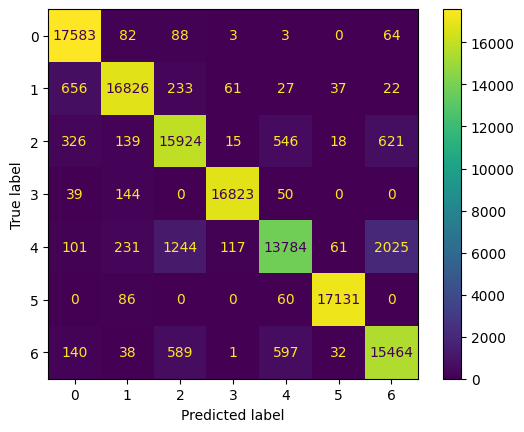

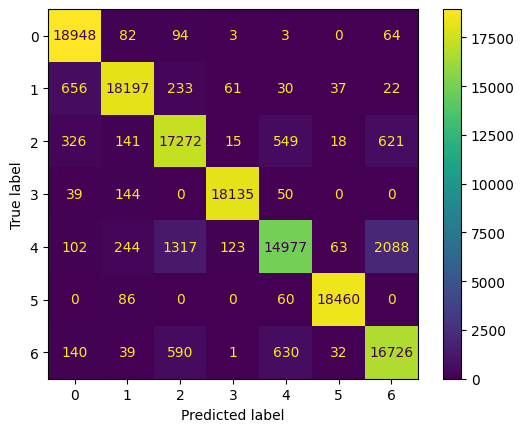

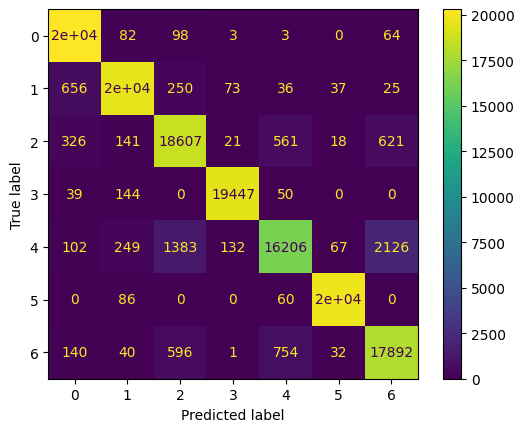

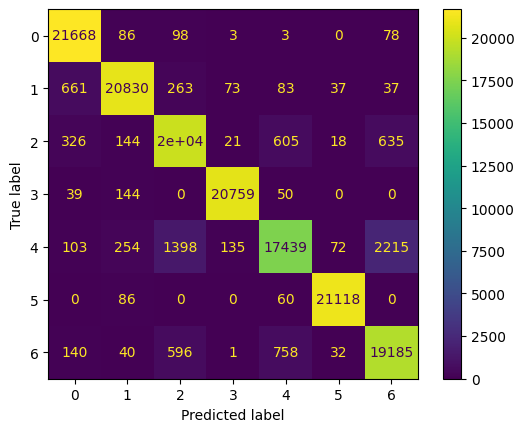

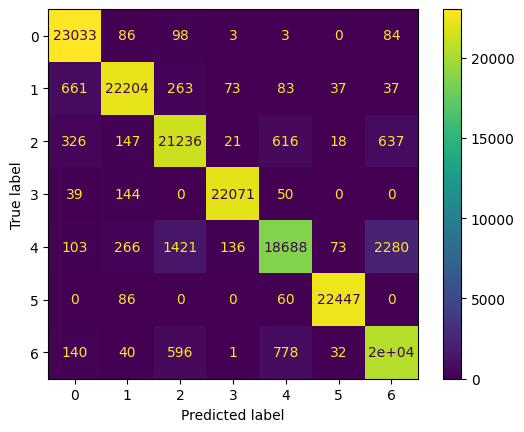

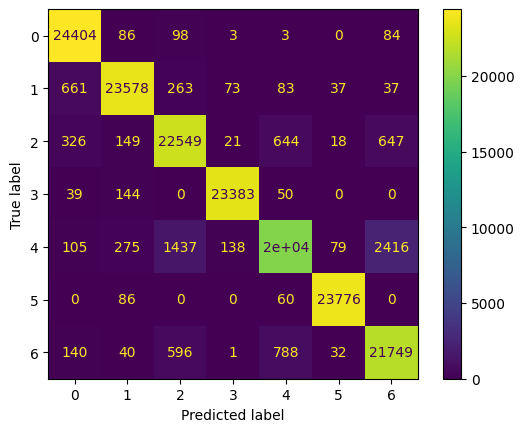

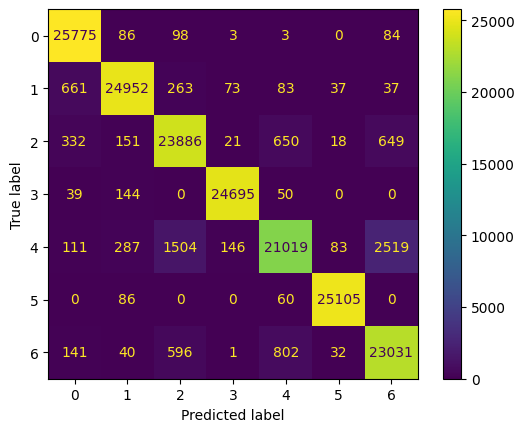

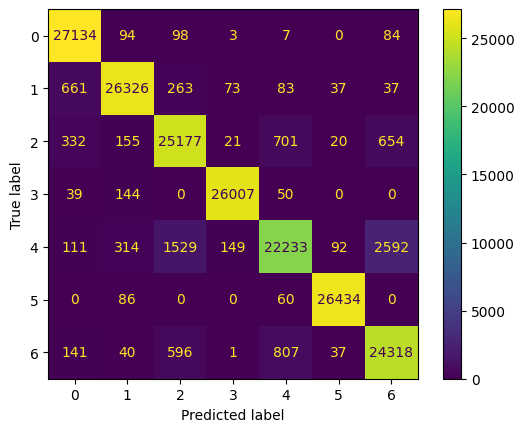

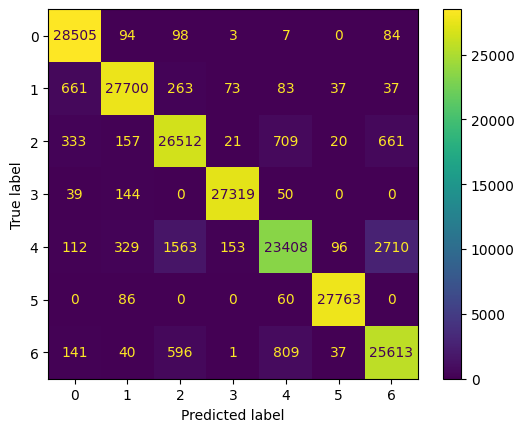

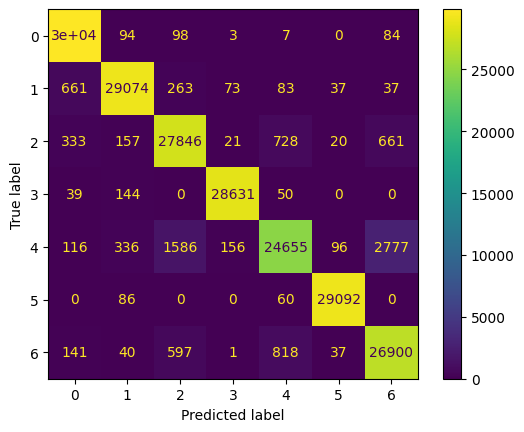

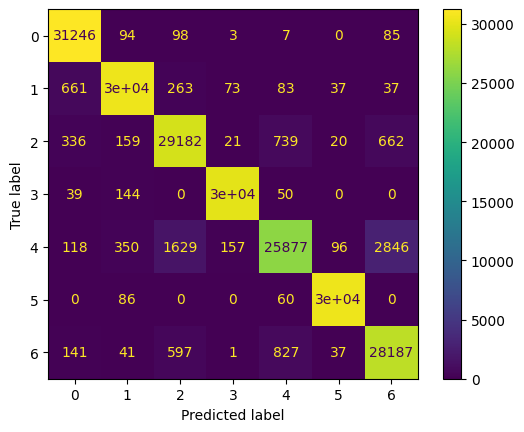

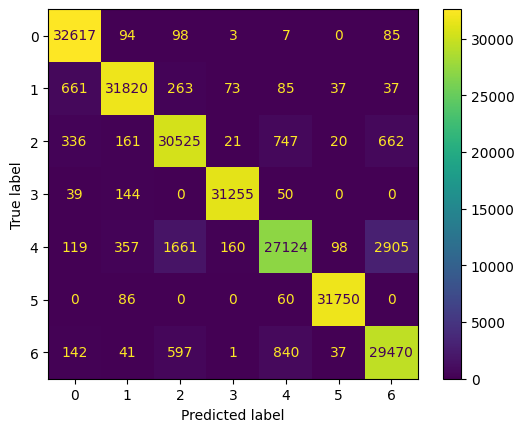

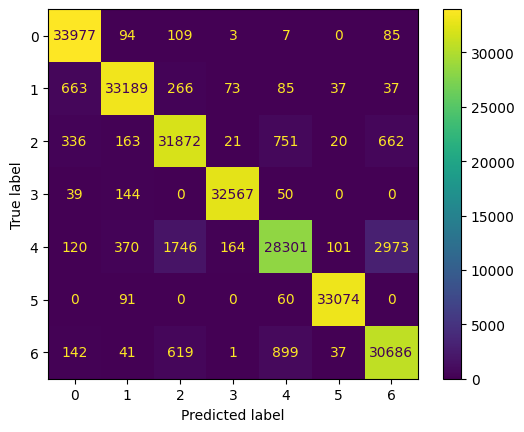

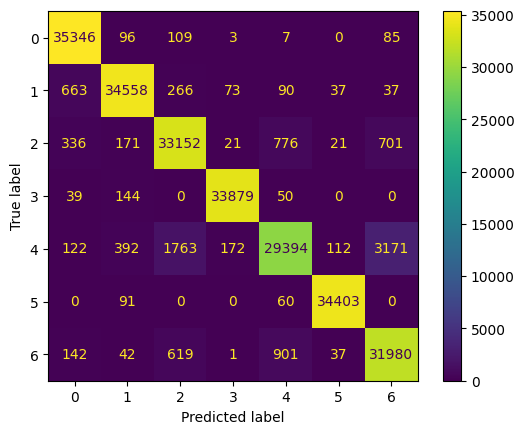

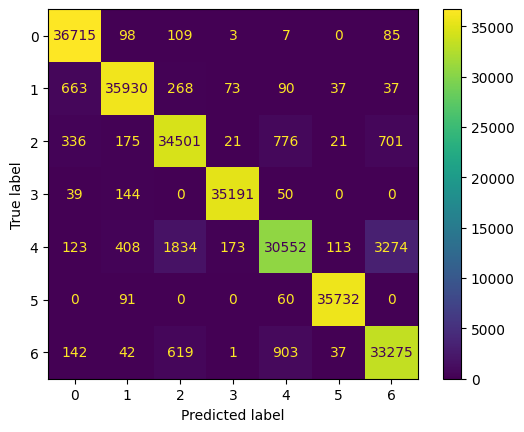

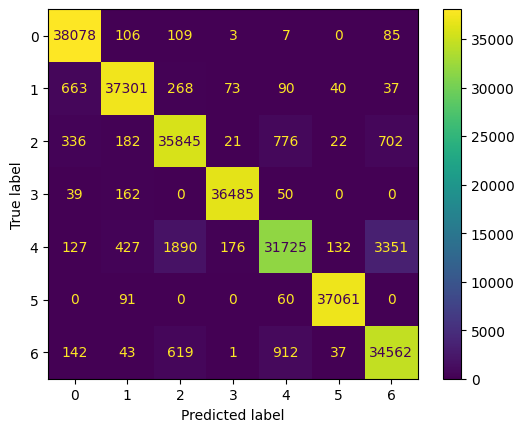

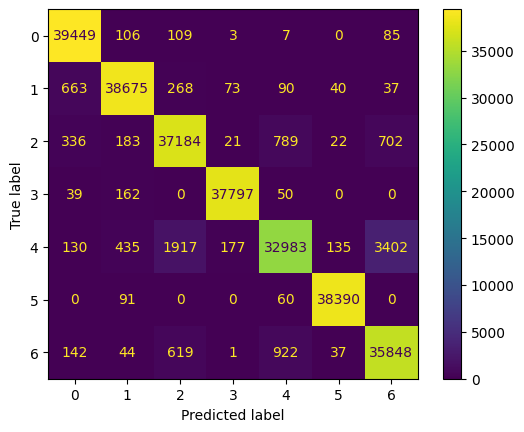

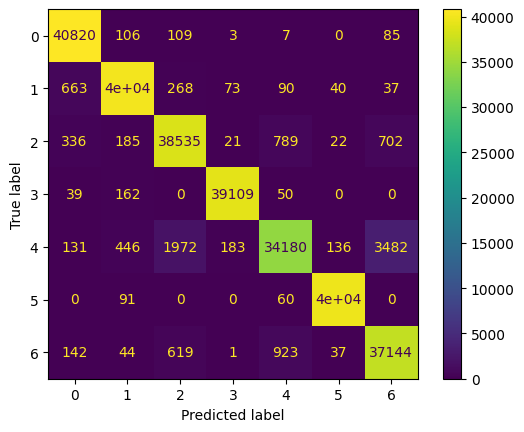

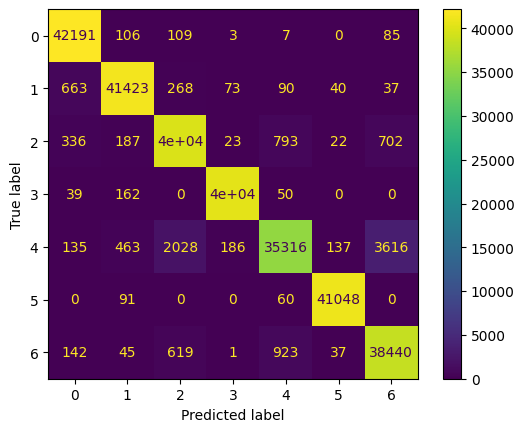

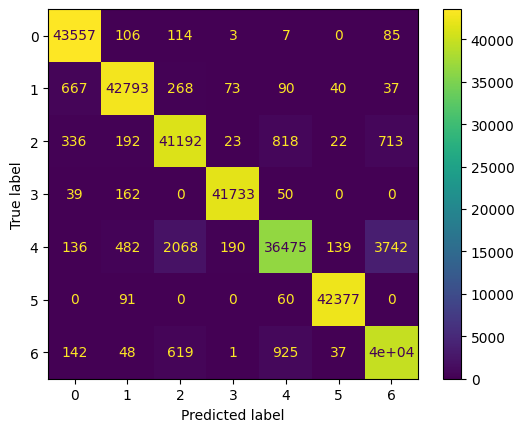

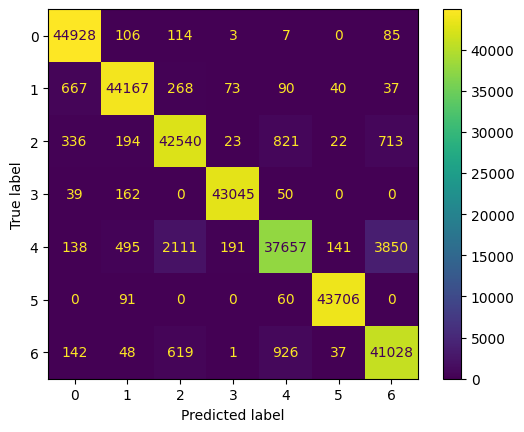

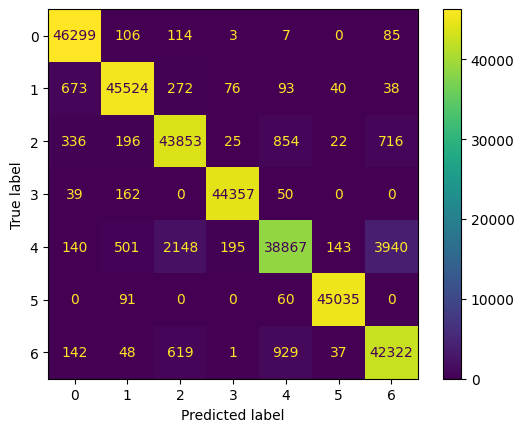

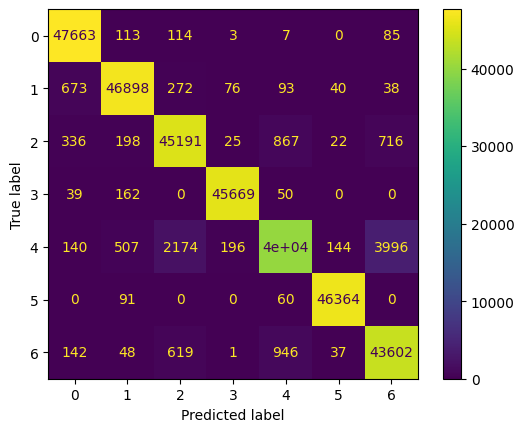

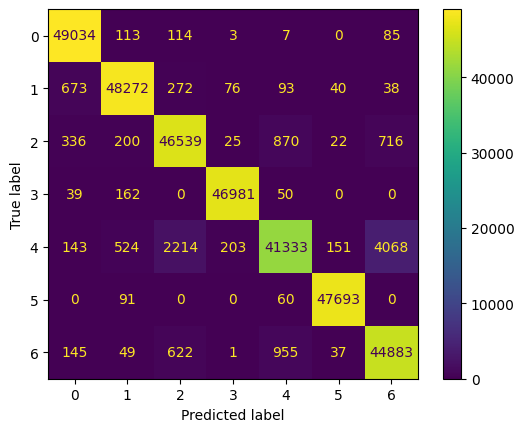

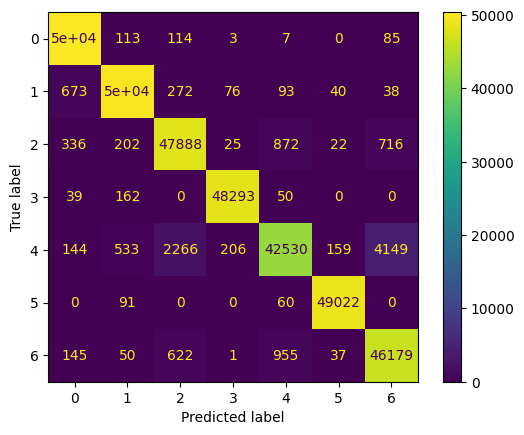

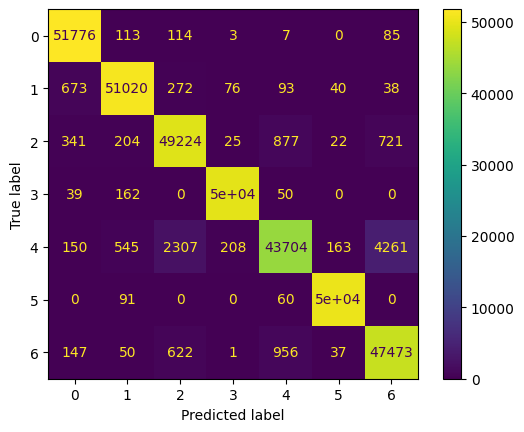

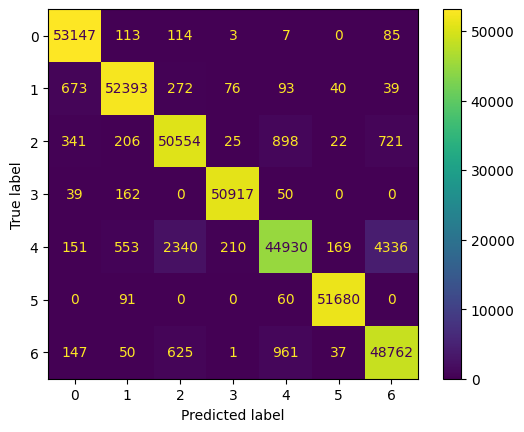

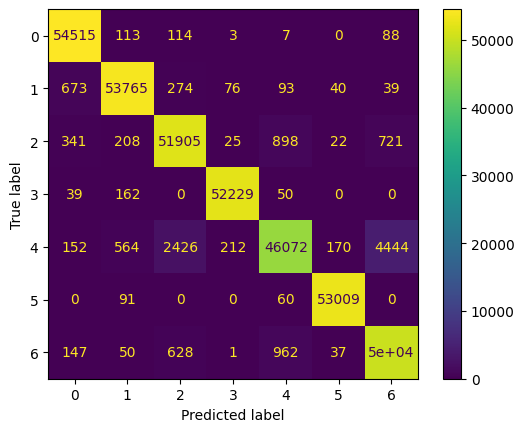

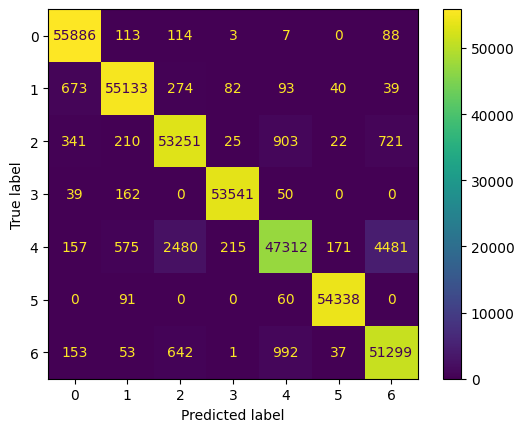

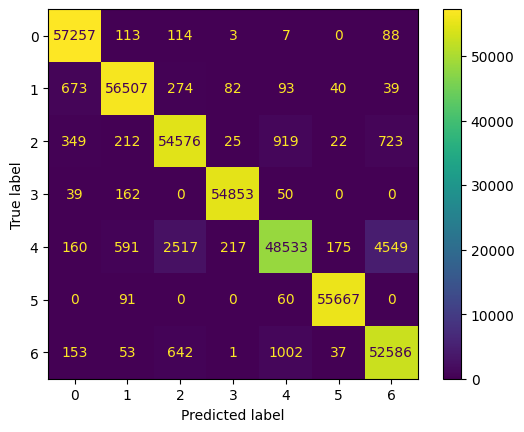

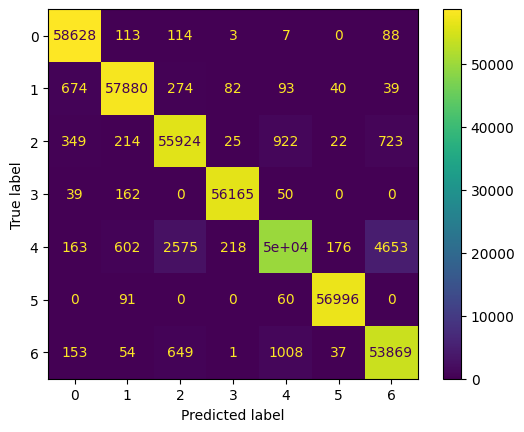

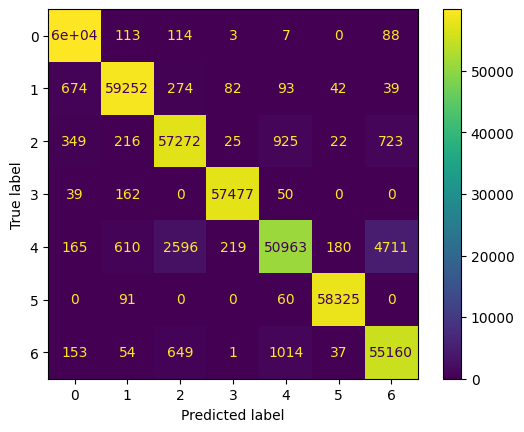

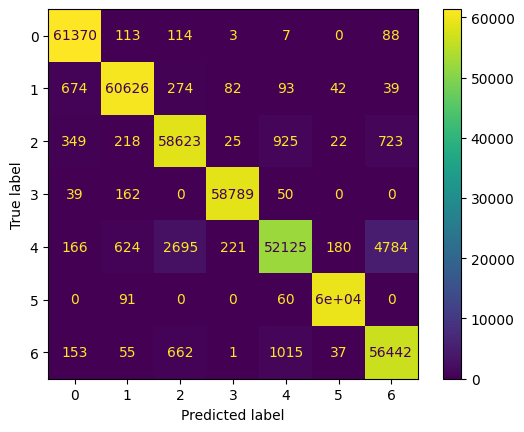

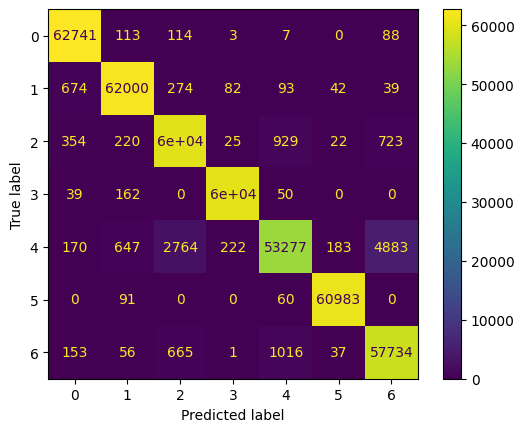

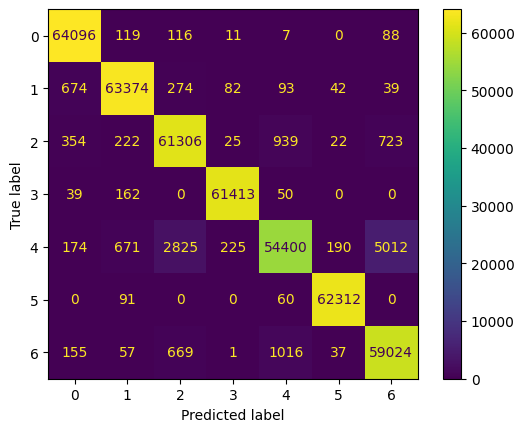

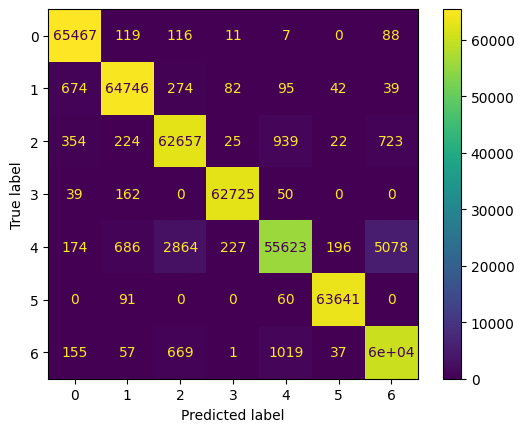

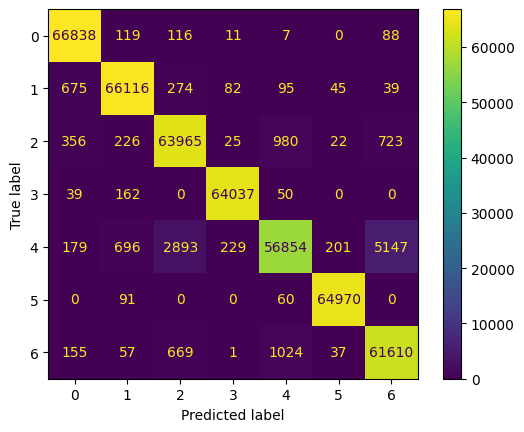

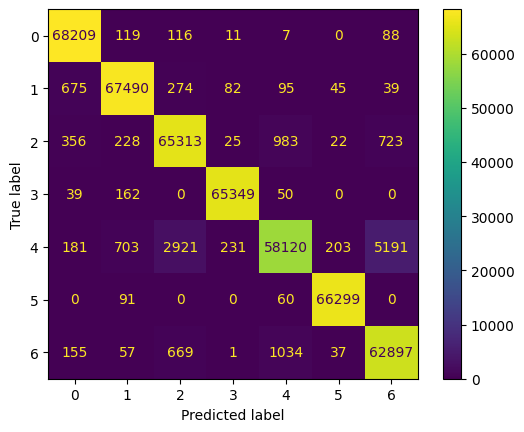

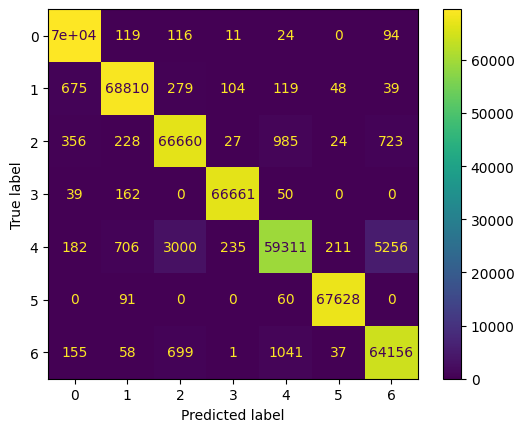

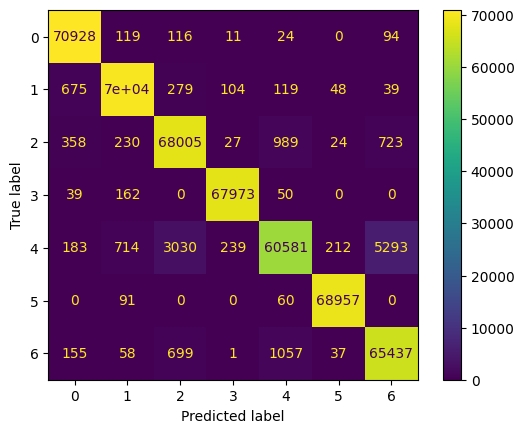

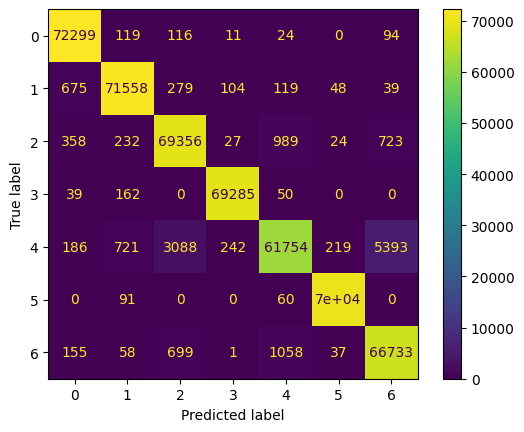

In [ ]:
results = []
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f"\n--- Fold {fold + 1} ---")

    train_subset = Subset(dataset, train_ids)
    val_subset = Subset(dataset, val_ids)

    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

    model = SkinCancer().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = torch.nn.CrossEntropyLoss()

    acc = train(train_loader, val_loader, loss_function, optimizer, model, device)
    print(f"Validation Accuracy for fold {fold + 1}: {acc:.4f}")
    results.append(acc)

print(f"\nAverage Accuracy across all folds: {sum(results)/len(results):.4f}")


In [ ]:
torch.save(model.state_dict(), 'models/skin_cancer.pth')

In [ ]:
evaluate(
    val_loader,
    model,
    loss_function
)